# Confidence and Accuracy Analysis

In [ ]:
# to sample:
# python -m LLM-Calibration-Study.simple_evals --model meta-llama/Meta-Llama-3.1-405B-Instruct-Turbo --benchmark mmlu_pro --conf_mode sampling --examples 3

# to eval:
# python -m LLM-Calibration-Study.simple_evals --model meta-llama/Meta-Llama-3.1-405B-Instruct-Turbo --benchmark mmlu_pro --conf_mode verbal_linguistic_shared_sampling --examples 3

In [35]:
from bs4 import BeautifulSoup
import re
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import pandas as pd
import seaborn as sns


In [ ]:
from bs4 import BeautifulSoup

def get_success_failed_indexes(file_path):
    """
    Extract sampled messages where the extracted answer is 'None'.
    """
    # Read the HTML file
    with open(file_path, "r", encoding="utf-8") as f:
        soup = BeautifulSoup(f, "html.parser")

    # Find all blocks containing "Sampled message"
    success = []
    failed = []
    i = 0
    for h3 in soup.find_all("h3"):
        if h3.text.strip() == "Sampled message":
            assistant_div = h3.find_next_sibling("div", class_="message assistant")
            results_h3 = assistant_div.find_next_sibling("h3")
            # Ensure it's the corresponding "Results" section
            if results_h3 and results_h3.text.strip() == "Results":
                # Look for "Extracted Answer"
                extracted_answer_p = results_h3.find_next_sibling("p", string=lambda t: t and "Extracted Answer:" in t)
                if extracted_answer_p and "None" in extracted_answer_p.text:
                    failed.append(i)
            success.append(i)
            i = i + 1
    # Remove failed indexes from success
    success = [i for i in success if i not in failed]
                    
    return np.array(success), np.array(failed)

def get_confidence(file_path):
    with open(file_path, "r", encoding="utf-8") as file:
        html_content = file.read()

    # Parse the HTML
    soup = BeautifulSoup(html_content, "html.parser")

    # Define a regex pattern for "Extracted Answer Confidence"
    pattern = re.compile(r"Extracted Answer Confidence:\s([0-1\]*\.?[0-9]+)")

    # Search through the text in the HTML
    matches = pattern.findall(soup.get_text())

    # Print the extracted confidence values
    return np.array(matches, dtype=float)

def get_accuracy(file_path):
    with open(file_path, "r", encoding="utf-8") as file:
        html_content = file.read()

    # Parse the HTML
    soup = BeautifulSoup(html_content, "html.parser")

    # Define a regex pattern for "Extracted Answer Confidence"
    pattern = re.compile(r"Score:\s([0-1]*\.?[0-9]+)")

    # Search through the text in the HTML
    matches = pattern.findall(soup.get_text())

    # Print the extracted confidence values
    return np.array(matches, dtype=float)

def get_subject(file_path):
    with open(file_path, "r", encoding="utf-8") as file:
        html_content = file.read()

    # Parse the HTML
    soup = BeautifulSoup(html_content, "html.parser")

    # Define a regex pattern for "Extracted Answer Confidence"
    pattern = re.compile(r'\nSubject:\s(.+)\n')

    # Search through the text in the HTML
    matches = pattern.findall(soup.get_text())

    # Print the extracted confidence values
    return (matches)

# AUROC

In [38]:
html_filename = """../results/mmlu_pro_{model}_{confidence}_shared_sampling_None.html"""
model = "Meta-Llama-3.1-405B-Instruct-Turbo"

In [ ]:
acc_list = get_accuracy(html_filename.format(model=model, confidence="verbal_numerical"))
verbal_num_conf = get_confidence(html_filename.format(model=model, confidence="verbal_numerical"))
logits_perp_conf = get_confidence(html_filename.format(model=model, confidence="logit_perplexity"))

In [46]:
verbal_linguistic_confidence_judge_mini = get_confidence("../results/linguistic-judges/mmlu_pro_Meta-Llama-3.1-405B-Instruct-Turbo_verbal_linguistic_shared_sampling_None_gpt-4.1-mini_dec_judge.html")
verbal_linguistic_confidence_judge_nano = get_confidence("../results/linguistic-judges/mmlu_pro_Meta-Llama-3.1-405B-Instruct-Turbo_verbal_linguistic_shared_sampling_None_gpt-4.1-nano_dec_judge.html")
verbal_linguistic_confidence_judge_deepseekv3 = get_confidence("../results/linguistic-judges/mmlu_pro_Meta-Llama-3.1-405B-Instruct-Turbo_verbal_linguistic_shared_sampling_None_deepseek-chat_dec_judge.html")
verbal_linguistic_confidence_judge_qwen3 = get_confidence("../results/linguistic-judges/mmlu_pro_Meta-Llama-3.1-405B-Instruct-Turbo_verbal_linguistic_shared_sampling_None_Qwen3-235B-A22B-fp8_dec_judge.html")
verbal_linguistic_confidence_judge_llama4_128E = get_confidence("../results/linguistic-judges/mmlu_pro_Meta-Llama-3.1-405B-Instruct-Turbo_verbal_linguistic_shared_sampling_None_Llama-4-Maverick-17B-128E-Instruct-FP8_dec_judge.html")
verbal_linguistic_confidence_judge_llama4_16E = get_confidence("../results/linguistic-judges/mmlu_pro_Meta-Llama-3.1-405B-Instruct-Turbo_verbal_linguistic_shared_sampling_None_Llama-4-Scout-17B-16E-Instruct_dec_judge.html")

In [47]:
mini_success_idx, _ = get_success_failed_indexes("../results/linguistic-judges/mmlu_pro_Meta-Llama-3.1-405B-Instruct-Turbo_verbal_linguistic_shared_sampling_None_gpt-4.1-mini_dec_judge.html")
nano_success_idx, _ = get_success_failed_indexes("../results/linguistic-judges/mmlu_pro_Meta-Llama-3.1-405B-Instruct-Turbo_verbal_linguistic_shared_sampling_None_gpt-4.1-nano_dec_judge.html")
deepseekv3_success_idx, _ = get_success_failed_indexes("../results/linguistic-judges/mmlu_pro_Meta-Llama-3.1-405B-Instruct-Turbo_verbal_linguistic_shared_sampling_None_deepseek-chat_dec_judge.html")
qwen3_success_idx, _ = get_success_failed_indexes("../results/linguistic-judges/mmlu_pro_Meta-Llama-3.1-405B-Instruct-Turbo_verbal_linguistic_shared_sampling_None_Qwen3-235B-A22B-fp8_dec_judge.html")
llama4_128E_success_idx, _ = get_success_failed_indexes("../results/linguistic-judges/mmlu_pro_Meta-Llama-3.1-405B-Instruct-Turbo_verbal_linguistic_shared_sampling_None_Llama-4-Maverick-17B-128E-Instruct-FP8_dec_judge.html")
llama4_16E_success_idx, _ = get_success_failed_indexes("../results/linguistic-judges/mmlu_pro_Meta-Llama-3.1-405B-Instruct-Turbo_verbal_linguistic_shared_sampling_None_Llama-4-Scout-17B-16E-Instruct_dec_judge.html")

In [48]:
from sklearn.metrics import roc_auc_score

print("Verbal Numberical Confidence AUROC:", roc_auc_score(acc_list, verbal_num_conf))
print("Logit Perplexity Confidence AUROC:", roc_auc_score(acc_list, logits_perp_conf))
print("Verbal Linguistic Confidence Judged by GPT-4.1-mini AUROC:", roc_auc_score(acc_list[mini_success_idx], verbal_linguistic_confidence_judge_mini[mini_success_idx]))
print("Verbal Linguistic Confidence Judged by GPT-4.1-nano AUROC:", roc_auc_score(acc_list[nano_success_idx], verbal_linguistic_confidence_judge_nano[nano_success_idx]))
print("Verbal Linguistic Confidence Judged by DeepSeekV3 AUROC:", roc_auc_score(acc_list[deepseekv3_success_idx], verbal_linguistic_confidence_judge_deepseekv3[deepseekv3_success_idx]))
print("Verbal Linguistic Confidence Judged by Qwen3 AUROC:", roc_auc_score(acc_list[qwen3_success_idx], verbal_linguistic_confidence_judge_qwen3[qwen3_success_idx]))
print("Verbal Linguistic Confidence Judged by Llama4-128E AUROC:", roc_auc_score(acc_list[llama4_128E_success_idx], verbal_linguistic_confidence_judge_llama4_128E[llama4_128E_success_idx]))
print("Verbal Linguistic Confidence Judged by Llama4-16E AUROC:", roc_auc_score(acc_list[llama4_16E_success_idx], verbal_linguistic_confidence_judge_llama4_16E[llama4_16E_success_idx]))

Verbal Numberical Confidence AUROC: 0.7222031678300018
Logit Perplexity Confidence AUROC: 0.6093670917491363
Verbal Linguistic Confidence Judged by GPT-4.1-mini AUROC: 0.739933870508449
Verbal Linguistic Confidence Judged by GPT-4.1-nano AUROC: 0.6523687076135689
Verbal Linguistic Confidence Judged by DeepSeekV3 AUROC: 0.6874685223926856
Verbal Linguistic Confidence Judged by Qwen3 AUROC: 0.6712655055980341
Verbal Linguistic Confidence Judged by Llama4-128E AUROC: 0.7325302885677452
Verbal Linguistic Confidence Judged by Llama4-16E AUROC: 0.6897315099195164


- GPT-4.1-mini
- GPT-4.1-nano
- meta-llama/Llama-2-70b-hf
- meta-llama/Llama-3.2-3B-Instruct-Turbo
- meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo
- meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo
- meta-llama/Meta-Llama-3.1-405B-Instruct-Turbo

In [44]:
print("Verbal Linguistic Confidence Judged by GPT-4.1-mini AUROC:", roc_auc_score(acc_list, verbal_linguistic_confidence_judge_mini))
print("Verbal Linguistic Confidence Judged by GPT-4.1-nano AUROC:", roc_auc_score(acc_list, verbal_linguistic_confidence_judge_nano))

Verbal Linguistic Confidence Judged by GPT-4.1-mini AUROC: 0.7427252398683525
Verbal Linguistic Confidence Judged by GPT-4.1-nano AUROC: 0.6509141429429313


## Confidence Distributions

In [5]:
html_filename = """../results/mmlu_pro_{model}_{confidence}_shared_sampling_None.html"""
all_models = [
              "Llama-3.2-3B-Instruct-Turbo",
              "Meta-Llama-3.1-8B-Instruct-Turbo",
              "Meta-Llama-3.1-70B-Instruct-Turbo",
              "Meta-Llama-3.1-405B-Instruct-Turbo",
              "gpt-4.1-nano", 
              "gpt-4.1-mini", 
              ]

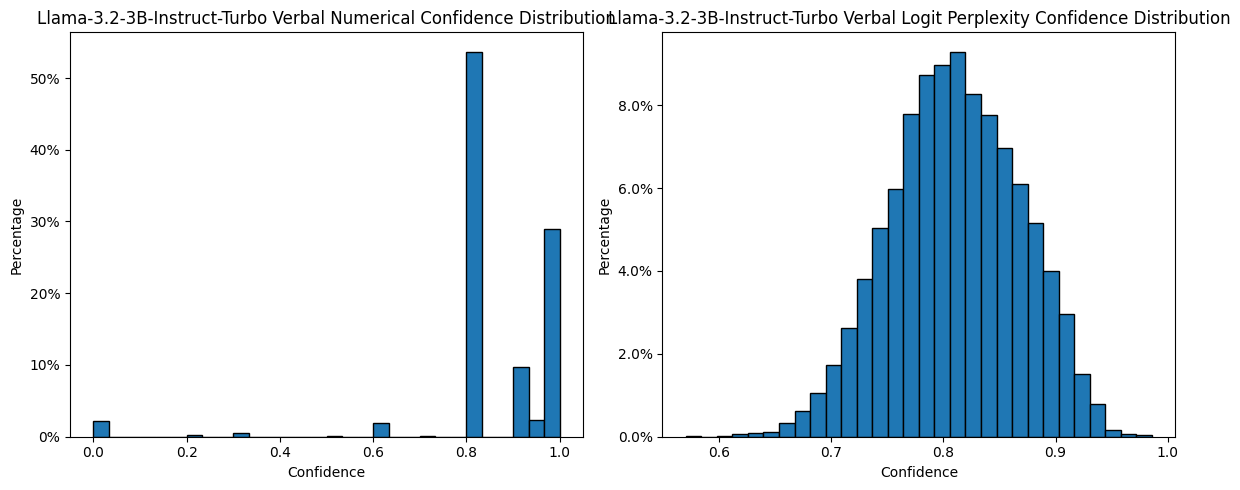

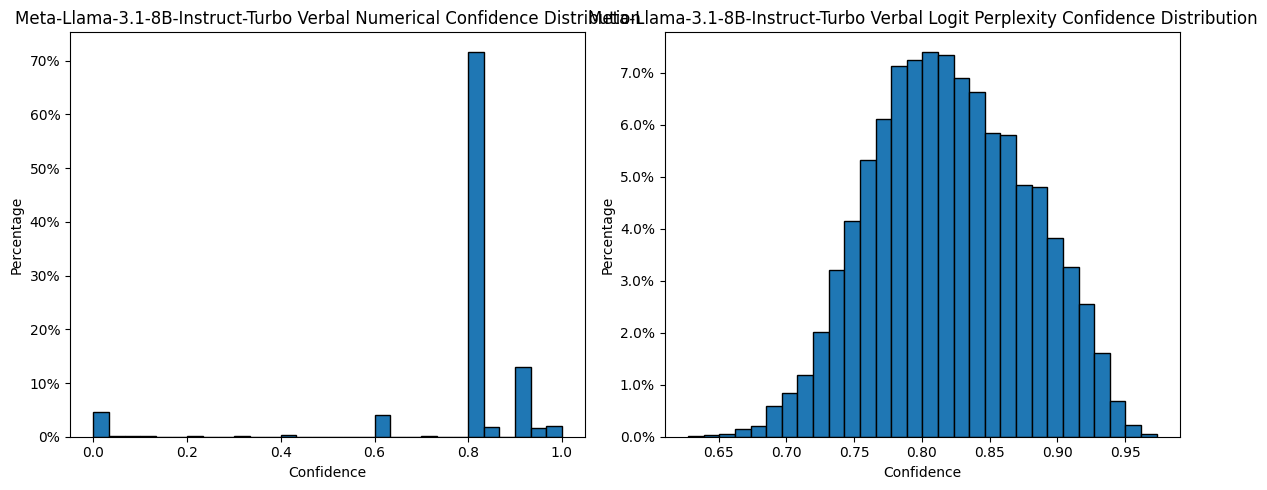

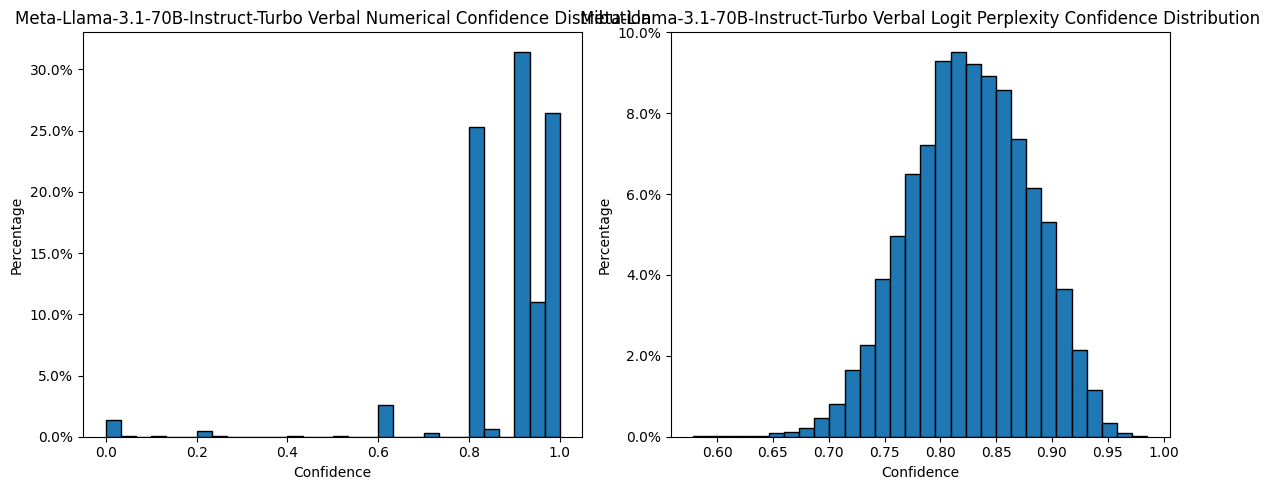

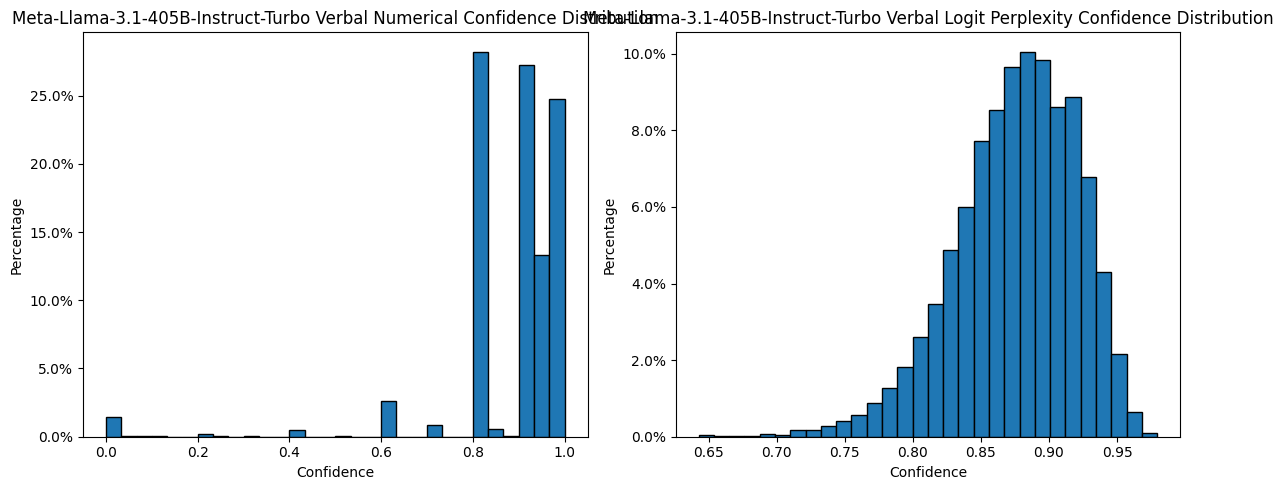

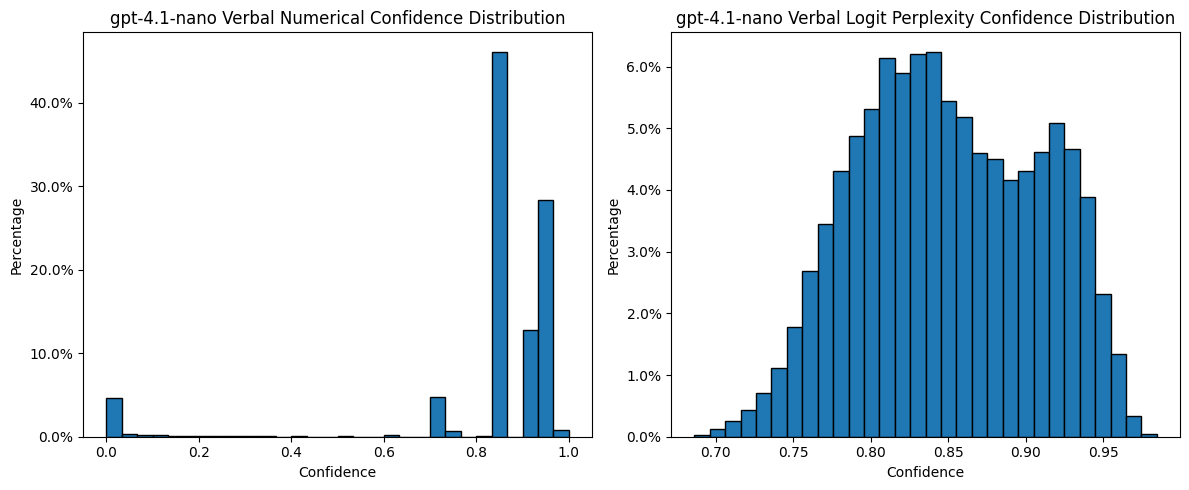

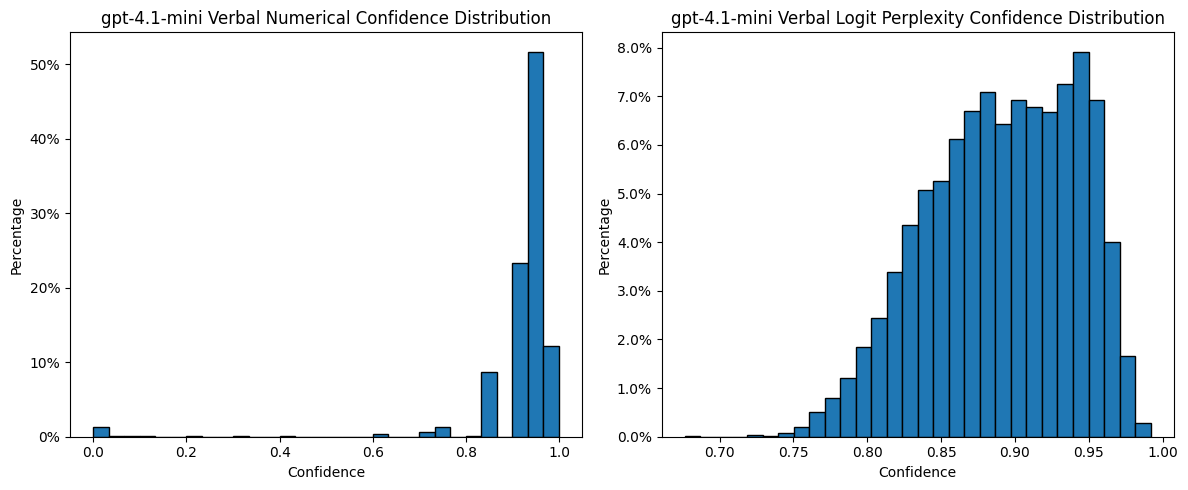

In [28]:
for model in all_models:
    verbal_num = get_confidence(html_filename.format(model=model, confidence="verbal_numerical"))
    logits_perp = get_confidence(html_filename.format(model=model, confidence="logit_perplexity"))

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # First histogram
    axes[0].hist(verbal_num, bins=30, weights=np.ones_like(verbal_num) / len(verbal_num), edgecolor='black')
    axes[0].yaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(1))
    axes[0].set_title(f'{model} Verbal Numerical Confidence Distribution')
    axes[0].set_xlabel('Confidence')
    axes[0].set_ylabel('Percentage')

    # Second histogram
    axes[1].hist(logits_perp, bins=30, weights=np.ones_like(logits_perp) / len(logits_perp), edgecolor='black')
    axes[1].yaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(1))
    axes[1].set_title(f'{model} Verbal Logit Perplexity Confidence Distribution')
    axes[1].set_xlabel('Confidence')
    axes[1].set_ylabel('Percentage')

    plt.tight_layout()
    plt.show()

In [53]:
verbal_linguistic_confidence_judge_nano

array([0.9, 0.8, 0.4, ..., 0.9, 1. , 0.5], shape=(12032,))

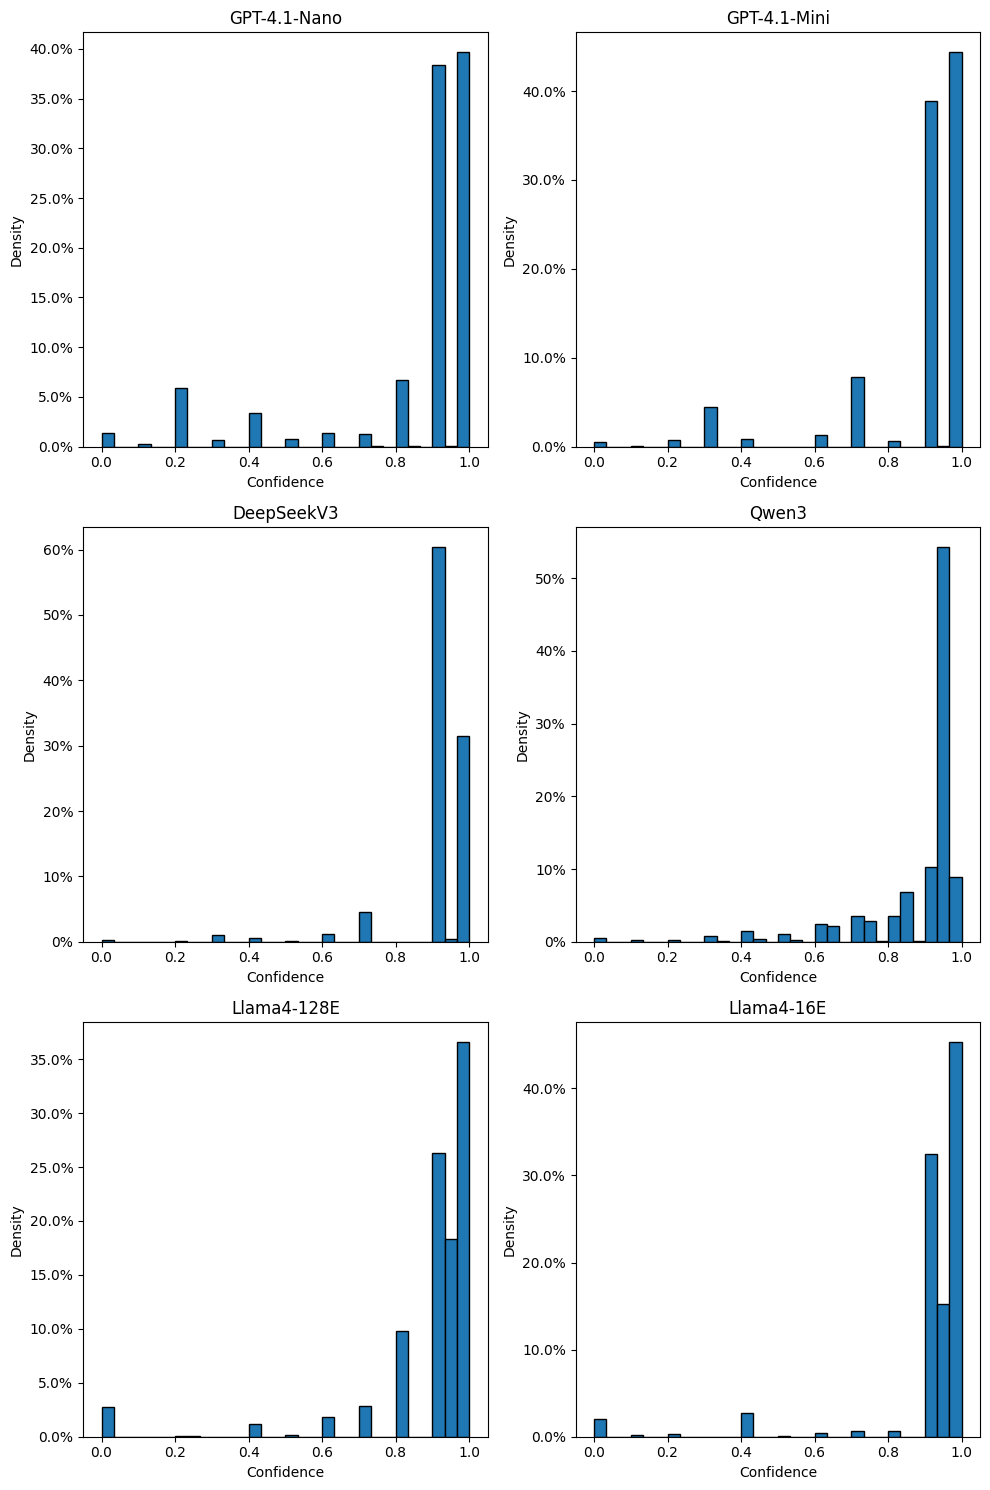

In [64]:

fig, axes = plt.subplots(3, 2, figsize=(10, 15))

# First histogram
axes[0,0].hist(verbal_linguistic_confidence_judge_nano, bins=30, weights=np.ones_like(verbal_linguistic_confidence_judge_nano) / len(verbal_linguistic_confidence_judge_nano), edgecolor='black')
axes[0,0].yaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(1))
axes[0,0].set_title(f'GPT-4.1-Nano')
axes[0,0].set_xlabel('Confidence')
axes[0,0].set_ylabel('Density')

# Second histogram
axes[0,1].hist(verbal_linguistic_confidence_judge_mini, bins=30, weights=np.ones_like(verbal_linguistic_confidence_judge_mini) / len(verbal_linguistic_confidence_judge_mini), edgecolor='black')
axes[0,1].yaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(1))
axes[0,1].set_title(f'GPT-4.1-Mini')
axes[0,1].set_xlabel('Confidence')
axes[0,1].set_ylabel('Density')

# Third histogram
axes[1,0].hist(verbal_linguistic_confidence_judge_deepseekv3, bins=30, weights=np.ones_like(verbal_linguistic_confidence_judge_deepseekv3) / len(verbal_linguistic_confidence_judge_deepseekv3), edgecolor='black')
axes[1,0].yaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(1))
axes[1,0].set_title(f'DeepSeekV3')
axes[1,0].set_xlabel('Confidence')
axes[1,0].set_ylabel('Density')

# Fourth histogram
axes[1,1].hist(verbal_linguistic_confidence_judge_qwen3, bins=30, weights=np.ones_like(verbal_linguistic_confidence_judge_qwen3) / len(verbal_linguistic_confidence_judge_qwen3), edgecolor='black')
axes[1,1].yaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(1))
axes[1,1].set_title(f'Qwen3')
axes[1,1].set_xlabel('Confidence')
axes[1,1].set_ylabel('Density')

# Fifth histogram
axes[2,0].hist(verbal_linguistic_confidence_judge_llama4_128E, bins=30, weights=np.ones_like(verbal_linguistic_confidence_judge_llama4_128E) / len(verbal_linguistic_confidence_judge_llama4_128E), edgecolor='black')
axes[2,0].yaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(1))
axes[2,0].set_title(f'Llama4-128E')
axes[2,0].set_xlabel('Confidence')
axes[2,0].set_ylabel('Density')

# Sixth histogram
axes[2,1].hist(verbal_linguistic_confidence_judge_llama4_16E, bins=30, weights=np.ones_like(verbal_linguistic_confidence_judge_llama4_16E) / len(verbal_linguistic_confidence_judge_llama4_16E), edgecolor='black')
axes[2,1].yaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(1))
axes[2,1].set_title(f'Llama4-16E')
axes[2,1].set_xlabel('Confidence')
axes[2,1].set_ylabel('Density')

plt.tight_layout()
plt.show()

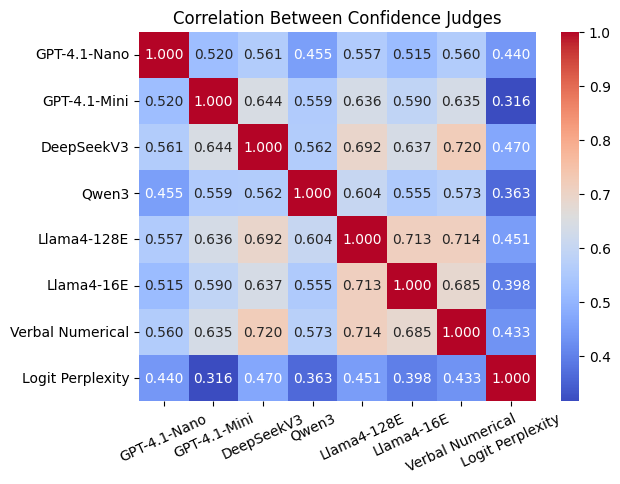

In [49]:
corr = pd.DataFrame({"GPT-4.1-Nano": verbal_linguistic_confidence_judge_nano, 
                     "GPT-4.1-Mini": verbal_linguistic_confidence_judge_mini,
                        "DeepSeekV3": verbal_linguistic_confidence_judge_deepseekv3,
                        "Qwen3": verbal_linguistic_confidence_judge_qwen3,
                        "Llama4-128E": verbal_linguistic_confidence_judge_llama4_128E,
                        "Llama4-16E": verbal_linguistic_confidence_judge_llama4_16E,
                        "Verbal Numerical": verbal_num_conf,
                        "Logit Perplexity": logits_perp_conf,
                     }).corr(method='spearman')
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".3f")
plt.title("Correlation Between Confidence Judges")
plt.xticks(rotation=25)
plt.show()

## ECE vs. Accuracy Scatter Plots

In [31]:
json_filesname = """../results/mmlu_pro_{model}_{confidence}_shared_sampling_None.json"""

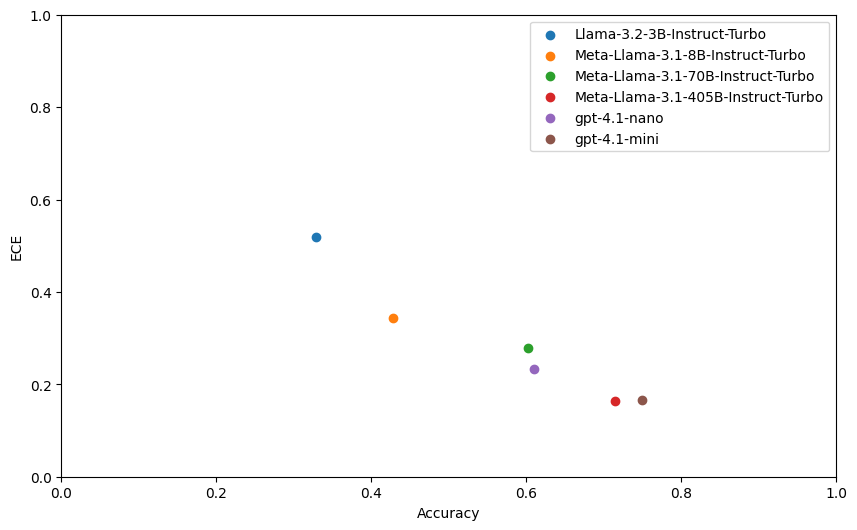

In [32]:
plt.figure(figsize=(10, 6))
for model in all_models:
    with open(json_filesname.format(model=model, confidence="verbal_numerical"), 'r') as f:
        verb_num = json.load(f)
    plt.xlim(left=0, right=1)
    plt.ylim(bottom=0, top=1)
    plt.scatter(verb_num["score"], verb_num["ECE"], label=model)
plt.xlabel("Accuracy")
plt.ylabel("ECE")
plt.legend()
plt.show()

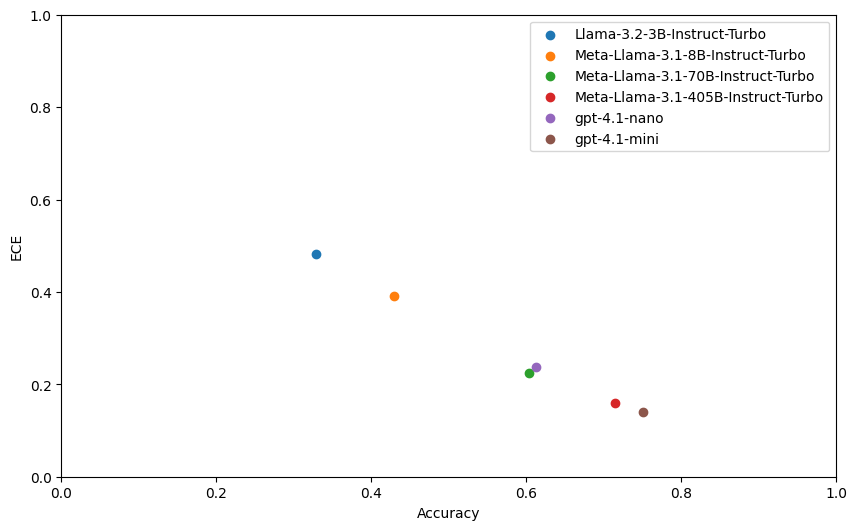

In [33]:
plt.figure(figsize=(10, 6))
for model in all_models:
    with open(json_filesname.format(model=model, confidence="logit_perplexity"), 'r') as f:
        logits_perp = json.load(f)
    plt.xlim(left=0, right=1)
    plt.ylim(bottom=0, top=1)
    plt.scatter(logits_perp["score"], logits_perp["ECE"], label=model)
plt.xlabel("Accuracy")
plt.ylabel("ECE")
plt.legend()
plt.show()    

# AUROC per model

In [ ]:
# python -m LLM-Calibration-Study.simple_evals --model gpt-4.1-nano --benchmark mmlu_pro --conf_mode logit_perplexity_shared_sampling 
# python -m LLM-Calibration-Study.simple_evals --model gpt-4.1-nano --benchmark mmlu_pro --conf_mode verbal_numerical_shared_sampling 

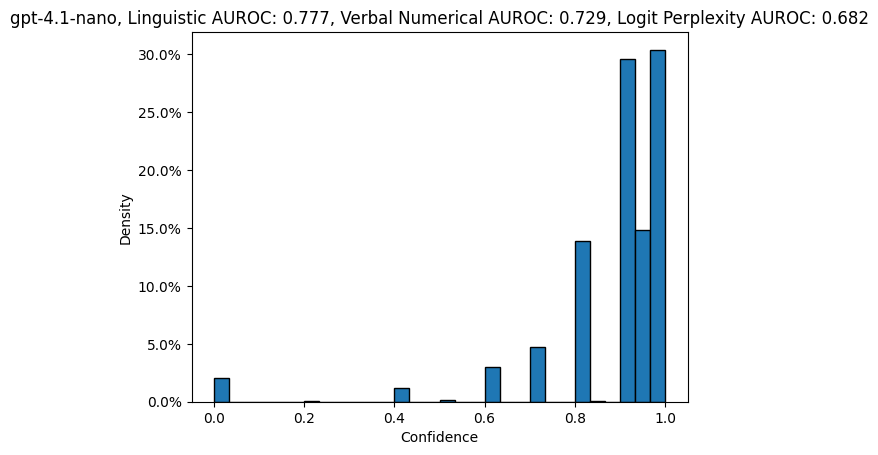

In [77]:
from sklearn.metrics import roc_auc_score
html_filename = """../results/mmlu_pro_{model}_{confidence}_shared_sampling_None.html"""
model_name = "gpt-4.1-nano"
linguistic_file_name = "../results/linguistic-judges/mmlu_pro_gpt-4.1-nano_verbal_linguistic_shared_sampling_None_meta-llama/Llama-4-Maverick-17B-128E-Instruct-FP8_dec_judge.html"


linguistic_conf = get_confidence(linguistic_file_name)
acc_list = get_accuracy(html_filename.format(model=model_name, confidence="verbal_numerical"))
verbal_num_conf = get_confidence(html_filename.format(model=model_name, confidence="verbal_numerical"))
logits_perp_conf = get_confidence(html_filename.format(model=model_name, confidence="logit_perplexity"))



plt.hist(linguistic_conf, bins=30, weights=np.ones_like(linguistic_conf) / len(linguistic_conf), edgecolor='black')
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(1))
plt.title(f'{model_name}, Linguistic AUROC: {roc_auc_score(acc_list, linguistic_conf):.3f}, Verbal Numerical AUROC: {roc_auc_score(acc_list, verbal_num_conf):.3f}, Logit Perplexity AUROC: {roc_auc_score(acc_list, logits_perp_conf):.3f}')
plt.xlabel('Confidence')
plt.ylabel('Density')
plt.show()

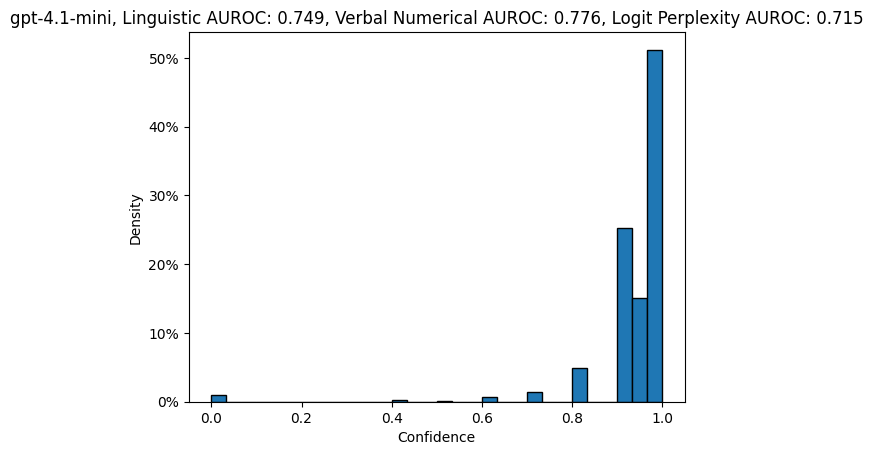

In [78]:
from sklearn.metrics import roc_auc_score
html_filename = """../results/mmlu_pro_{model}_{confidence}_shared_sampling_None.html"""
model_name = "gpt-4.1-mini"
linguistic_file_name = "../results/linguistic-judges/mmlu_pro_gpt-4.1-mini_verbal_linguistic_shared_sampling_None_meta-llama/Llama-4-Maverick-17B-128E-Instruct-FP8_dec_judge.html"


linguistic_conf = get_confidence(linguistic_file_name)
logits_perp_conf = get_confidence(html_filename.format(model=model_name, confidence="logit_perplexity"))
verbal_num_conf = get_confidence(html_filename.format(model=model_name, confidence="verbal_numerical"))
acc_list = get_accuracy(html_filename.format(model=model_name, confidence="verbal_numerical"))


plt.hist(linguistic_conf, bins=30, weights=np.ones_like(linguistic_conf) / len(linguistic_conf), edgecolor='black')
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(1))
plt.title(f'{model_name}, Linguistic AUROC: {roc_auc_score(acc_list, linguistic_conf):.3f}, Verbal Numerical AUROC: {roc_auc_score(acc_list, verbal_num_conf):.3f}, Logit Perplexity AUROC: {roc_auc_score(acc_list, logits_perp_conf):.3f}')
plt.xlabel('Confidence')
plt.ylabel('Density')
plt.show()

# Confidence Corrolation

In [34]:
filenames = [os.path.join("../results", f) for f in os.listdir('../results/')  if not f.startswith('.') and not f.startswith('linguistic') and not f.endswith(".json")] + [os.path.join("../results/linguistic-judges", f) for f in os.listdir('../results/linguistic-judges') if not f.startswith('.') and not f.startswith('linguistic') and not f.endswith(".json")] 
filenames = sorted(filenames)

In [35]:
# names = {
# '../results/mmlu_pro_Llama-3.2-3B-Instruct-Turbo_logit_perplexity_shared_sampling_None.html': "Llama-3.2-3B-Instruct-Turbo Logit Perplexity",
#  '../results/mmlu_pro_gpt-4.1-mini_verbal_numerical_shared_sampling_None.html': "GPT-4.1-Mini Verbal Numerical",
#  '../results/mmlu_pro_gpt-4.1-mini_logit_perplexity_shared_sampling_None.html' : "GPT-4.1-Mini Logit Perplexity",
#  '../results/mmlu_pro_Meta-Llama-3.1-8B-Instruct-Turbo_logit_perplexity_shared_sampling_None.html' : "Meta-Llama-3.1-8B-Instruct-Turbo Logit Perplexity",
#  '../results/mmlu_pro_Meta-Llama-3.1-8B-Instruct-Turbo_verbal_numerical_shared_sampling_None.html',
#  '../results/mmlu_pro_gpt-4.1-nano_logit_perplexity_shared_sampling_None.html',
#  '../results/mmlu_pro_Meta-Llama-3.1-405B-Instruct-Turbo_verbal_numerical_shared_sampling_None.html',
#  '../results/mmlu_pro_Meta-Llama-3.1-70B-Instruct-Turbo_verbal_numerical_shared_sampling_None.html',
#  '../results/mmlu_pro_gpt-4.1-nano_verbal_numerical_shared_sampling_None.html',
#  '../results/mmlu_pro_Meta-Llama-3.1-405B-Instruct-Turbo_logit_perplexity_shared_sampling_None.html',
#  '../results/mmlu_pro_Meta-Llama-3.1-70B-Instruct-Turbo_logit_perplexity_shared_sampling_None.html',
#  '../results/mmlu_pro_Llama-3.2-3B-Instruct-Turbo_verbal_numerical_shared_sampling_None.html',
#  '../results/linguistic-judges/mmlu_pro_Meta-Llama-3.1-405B-Instruct-Turbo_verbal_linguistic_shared_sampling_None_gpt-4.1-mini_dec_judge.html',
#  '../results/linguistic-judges/mmlu_pro_Meta-Llama-3.1-405B-Instruct-Turbo_verbal_linguistic_shared_sampling_None_gpt-4.1-nano_dec_judge.html
# }

In [36]:
conf_dict = dict()
for file in filenames:
    conf_dict[file] = get_confidence(file)
    print(len(conf_dict[file]))

12032
12032
12032
12032
12032


KeyboardInterrupt: 

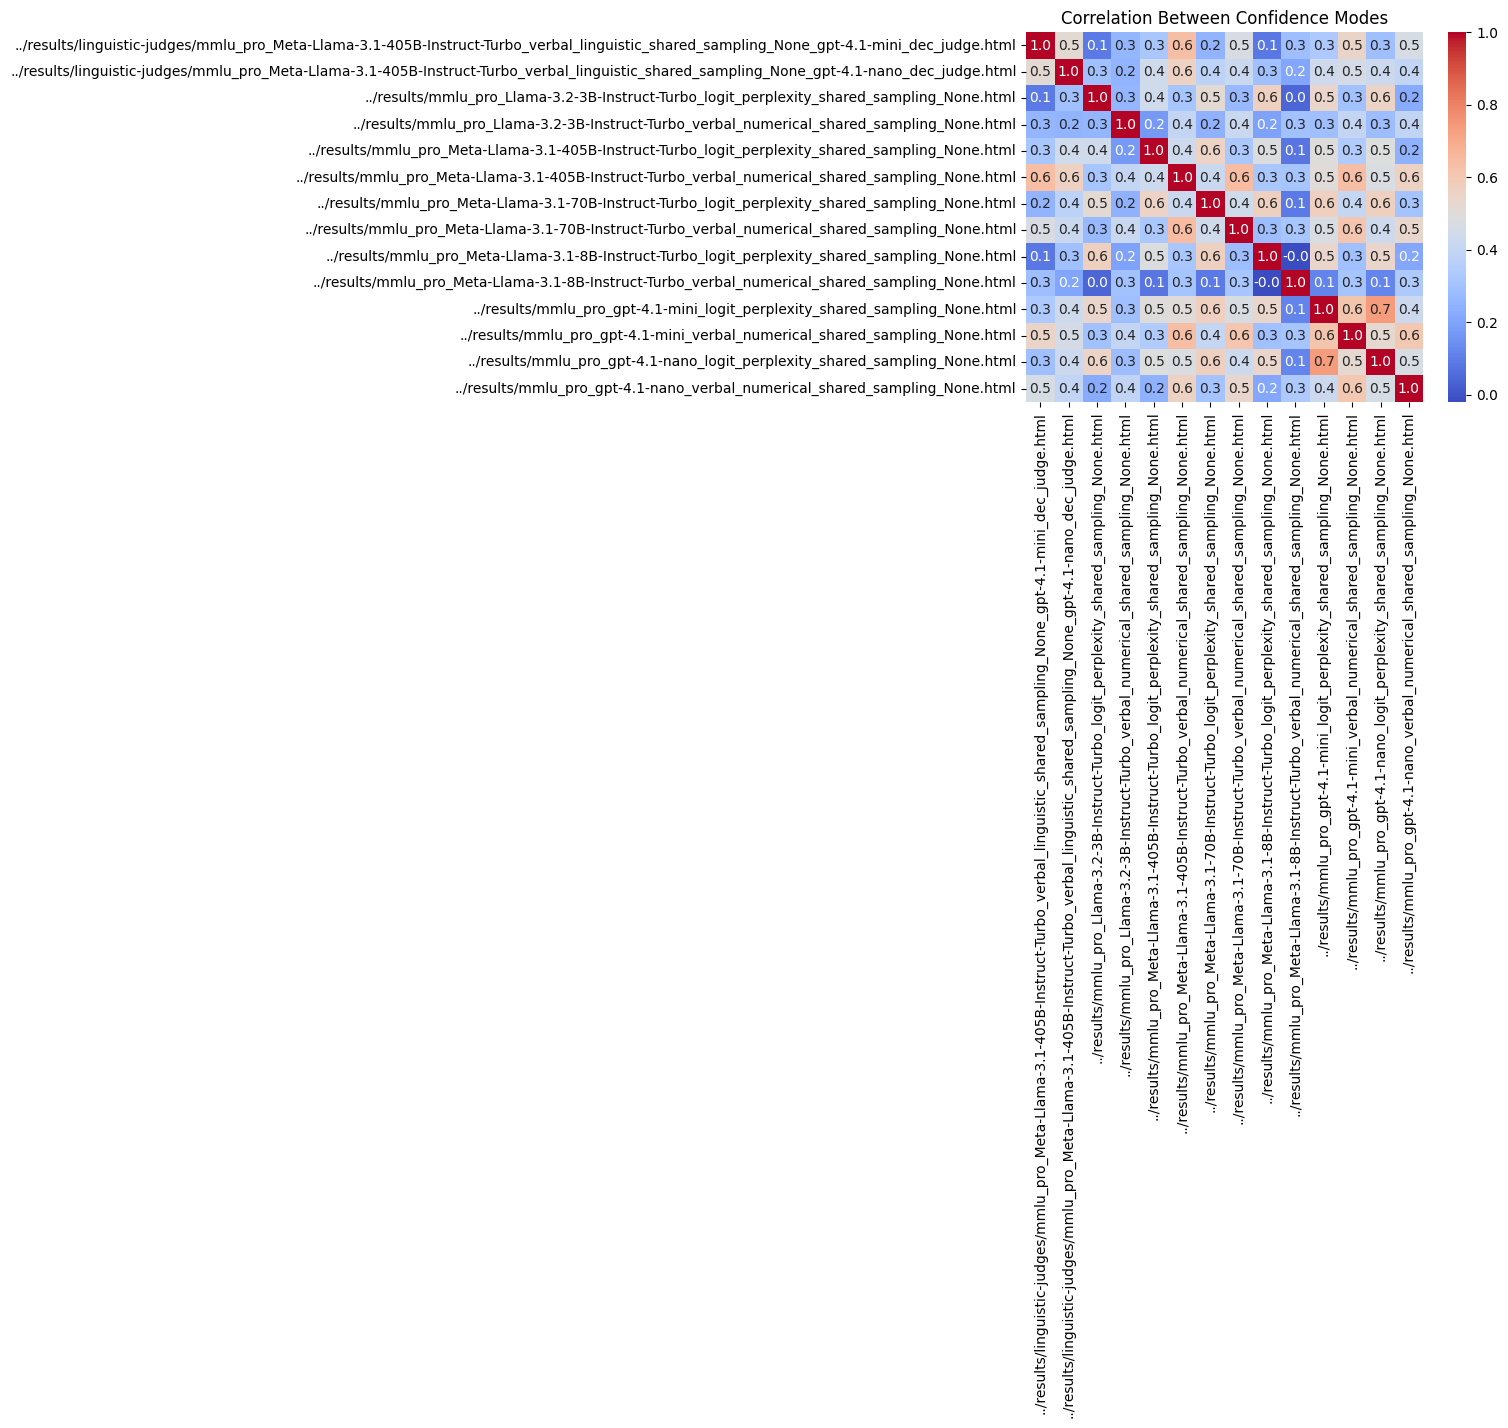

In [ ]:
df = pd.DataFrame(conf_dict)
corr = df.corr(method='spearman')
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".1f")
plt.title("Correlation Between Confidence Modes")
plt.xticks(rotation=90)
plt.show()